In [1]:
import pyspark
import pyspark.sql.types as stypes
import pyspark.sql.functions as F
from pyspark.sql.types import StructType, StructField, LongType
from pyspark.sql.functions import pandas_udf
from pyspark.sql.window import Window

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
spark = pyspark.sql.SparkSession.builder.master("local").getOrCreate()
spark

# Load data

In [3]:
def save_parquet(filename, df, host="hdfs://ca4022-m"):
    df.write.save(host + filename, format="parquet", mode="overwrite")
    
def read_parquet(filename, host="hdfs://ca4022-m"):
    return spark.read.load(host + filename)

In [4]:
df = read_parquet("/user/adam/parquet/cleaned2")

In [7]:
df.show(1, vertical=True, truncate=False)

-RECORD 0-------------------------------------------------------
 Category            | 1081390                                  
 Item_Number         | 69945                                    
 Vendor_Number       | 260                                      
 County_Number       | 77                                       
 Zip_Code            | 50265                                    
 Store_Number        | 2648                                     
 Date                | 2012-10-24                               
 Pack                | 12                                       
 Bottle_Volume_ml    | 375                                      
 State_Bottle_Cost   | 6.75                                     
 State_Bottle_Retail | 10.12                                    
 Bottles_Sold        | 3                                        
 Sale_Dollars        | 30.36                                    
 Volume_Sold_Liters  | 1.12                                     
 Volume_Sold_Gallons | 0.

# Alcohol over time

In [17]:
def same_year(date):
    day = pd.to_datetime(date).day
    month = pd.to_datetime(date).month
    
    return pd.to_datetime(f"2012-{month}-{day}")

In [9]:
alch_sold = df.groupBy("Date") \
.agg(F.sum("Volume_Sold_Liters").alias("litres_sold")).toPandas()

In [10]:
alch_sold["Date"] = pd.to_datetime(alch_sold["Date"])

### Simple view of sales over time

Text(0, 0.5, 'Litres Sold')

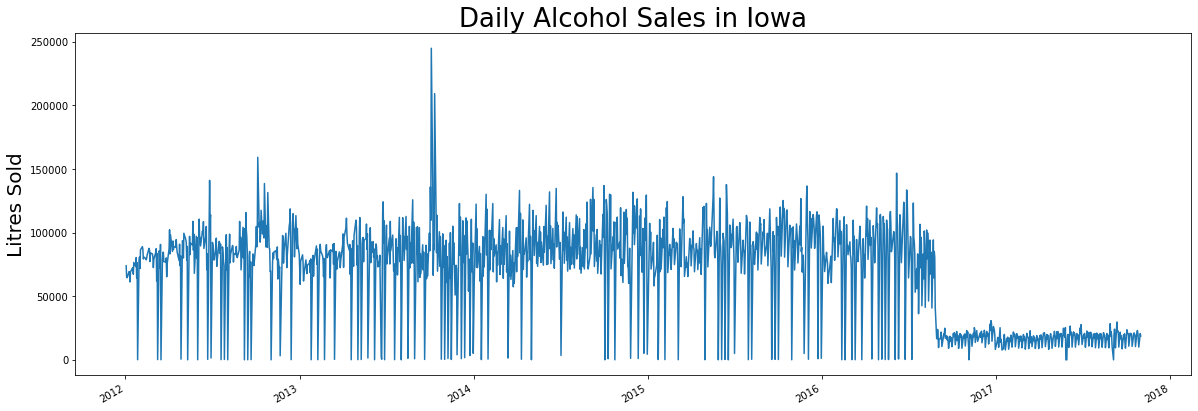

In [16]:
fig, ax = plt.subplots(figsize=(20, 7))
alch_sold.plot(x="Date", ax=ax, legend=None)
plt.title("Daily Alcohol Sales in Iowa", fontsize=26)
plt.xlabel("")
plt.ylabel("Litres Sold", fontsize=20)

### Sales over the course of a year

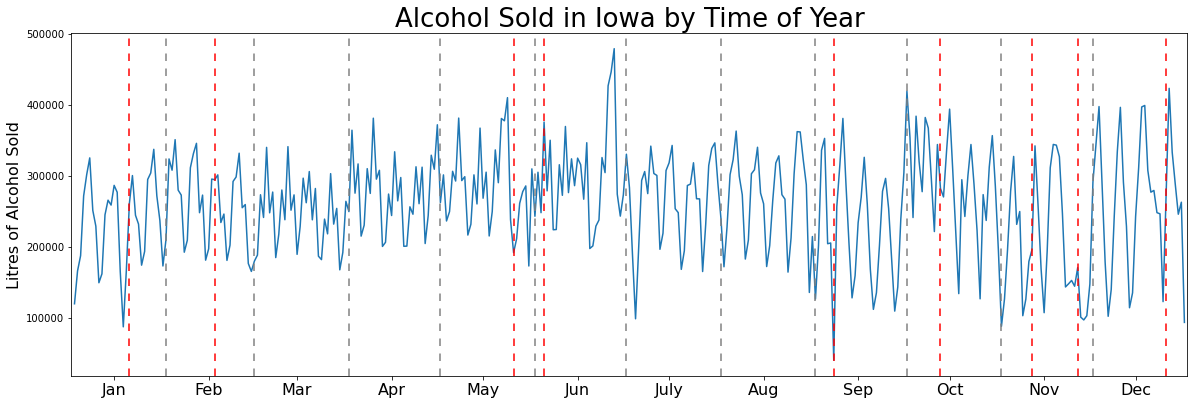

In [18]:
fig, ax = plt.subplots(figsize=(20,7))
data = alch_sold.groupby(alch_sold["Date"].apply(same_year))["litres_sold"].sum()
data.plot(x="Date", y="litres_sold", ax=ax, legend=None)

# Set x axis labels
ax.set_xticks([f"2012-{i+1:d}-15" for i in range(12)])
ax.set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "July", "Aug", "Sep", "Oct", "Nov", "Dec"],
                   rotation=0, ha="center", fontsize=16)
ax.set_xlim("2012-01-01", "2013-01-01")

# Set titles
ax.set_title("Alcohol Sold in Iowa by Time of Year", fontsize=26)
ax.set_xlabel("")
ax.set_ylabel("Litres of Alcohol Sold", fontsize=16)


# Plot month borders
for i in range(1, 12):
    ax.axvline(f"2012-{i+1:d}-01", c="grey", dashes=(5, 5))

# Plot holidays
## Thanksgiving https://american.bank/bank-holidays
holidays = [
    "2012-01-20",
    "2012-02-17",
    "2012-05-25",
    "2012-06-04",
    "2012-09-07",
    "2012-10-12",
    "2012-11-11",
    "2012-11-26",
    "2012-12-25",
]

for h in holidays:
    ax.axvline(h, c="r", dashes=(5, 5))

### Alcohol sales over the course of a week

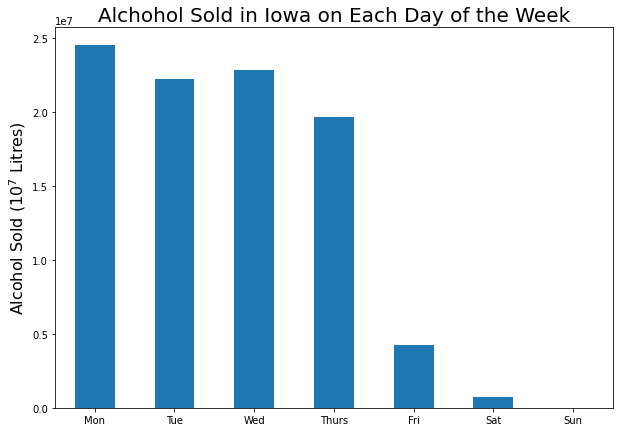

In [19]:
fig, ax = plt.subplots(figsize=(10, 7))
alch_sold.groupby(alch_sold["Date"].dt.weekday).sum().plot.bar(ax=ax)

plt.xlabel("Day")
plt.xticks(range(7), ["Mon", "Tue", "Wed", "Thurs", "Fri", "Sat", "Sun"],
           rotation=0, ha="center")

plt.ylabel("Alcohol Sold ($10^7$ Litres)", fontsize=16)
plt.xlabel("")
plt.title("Alchohol Sold in Iowa on Each Day of the Week", fontsize=20)

plt.legend().remove()
plt.xlim(-0.5, 6.5)
plt.show()

### Consumption of different types of alcohol over time

In [97]:
cat_bottles = df.groupBy("Date", "Category").agg(
    F.first("Category_Name").alias("category"),
    F.sum("Bottles_Sold").alias("bottles")
).orderBy(["Date", "bottles"], ascending=[1, 0]).toPandas()

In [98]:
cat_bottles["Date"] = pd.to_datetime(cat_bottles["Date"])

In [99]:
# Get top 10 most sold categories
top = cat_bottles.groupby("category")["bottles"].sum().sort_values()[::-1].head(10).index
top

Index(['VODKA 80 PROOF', 'CANADIAN WHISKIES', 'SPICED RUM', 'BLENDED WHISKIES',
       'STRAIGHT BOURBON WHISKIES', 'TEQUILA', 'WHISKEY LIQUEUR',
       'VODKA FLAVORED', 'IMPORTED VODKA', 'PUERTO RICO & VIRGIN ISLANDS RUM'],
      dtype='object', name='category')

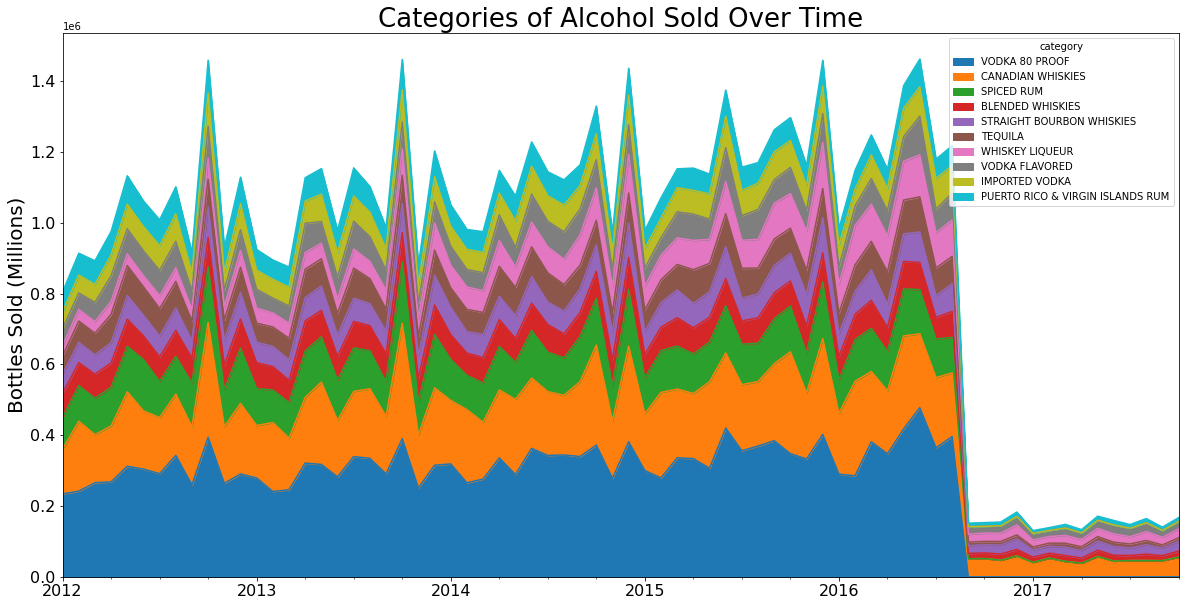

In [100]:
fig, ax = plt.subplots(figsize=(20, 10))
cat_bottles.groupby([pd.Grouper(key="Date", freq="1M"), "category"])["bottles"].sum().reset_index() \
.pivot_table(index="Date", columns="category", values="bottles")[top].plot.area(ax=ax)

plt.title("Categories of Alcohol Sold Over Time", fontsize=26)
plt.xlabel("")
plt.ylabel("Bottles Sold (Millions)", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

# Most Popular Stores

In [23]:
store_transactions = df.groupby("Store_Name") \
.agg(F.sum("Bottles_Sold").alias("bottles")) \
.orderBy("bottles", ascending=False).toPandas()

In [24]:
store_transactions.rename(columns={"Store_Name": "Store", "bottles": "Bottles Sold"}).head(5)

,Store,Bottles Sold
0,Hy-Vee #3 / BDI / Des Moines,2759980
1,Central City 2,1910141
2,Hy-Vee Wine and Spirits / Iowa City,1288319
3,Sam's Club 8162 / Cedar Rapids,1155985
4,Sam's Club 6344 / Windsor Heights,1089468


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Hy-Vee #3 / BDI / Des Moines'),
  Text(1, 0, 'Central City 2'),
  Text(2, 0, 'Hy-Vee Wine and Spirits / Iowa City'),
  Text(3, 0, "Sam's Club 8162 / Cedar Rapids"),
  Text(4, 0, "Sam's Club 6344 / Windsor Heights"),
  Text(5, 0, 'Central City Liquor, Inc.'),
  Text(6, 0, 'Lot-A-Spirits'),
  Text(7, 0, 'Wilkie Liquors'),
  Text(8, 0, "Sam's Club 8238 / Davenport"),
  Text(9, 0, 'Hy-Vee Wine and Spirits #2')])

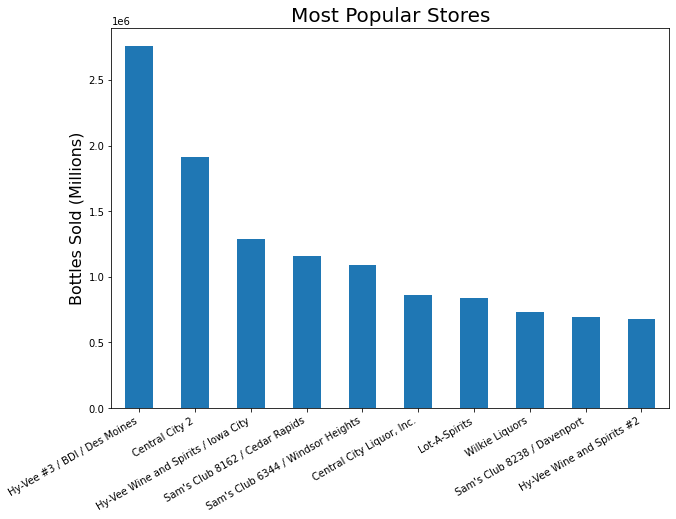

In [33]:
fig, ax = plt.subplots(figsize=(10, 7))
store_transations.head(10).plot.bar(x="Store_Name", ax=ax, legend=None)

plt.title("Most Popular Stores", fontsize=20)
plt.xlabel("")
plt.ylabel("Bottles Sold (Millions)", fontsize=16)

plt.xticks(ha="right", rotation=30)
plt.show()

# Store Location

In [37]:
# Filter locations that are outside of Iowa
df_loc = df.filter(
    (40 < df.median_lat) & 
    (df.median_lat < 44) & 
    (-97 < df.median_lon) & 
    (df.median_lon < -90)
)

### Where is each store located?

In [39]:
locations = df_loc.groupby("Store_Number", "Zip_Code").agg(
    F.first("median_lat").alias("lat"),
    F.first("median_lon").alias("lon"),
).toPandas()

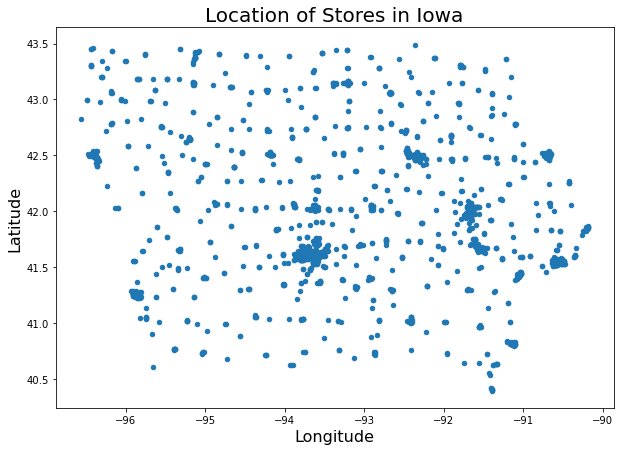

In [40]:
fig, ax = plt.subplots(figsize=(10, 7))
locations.plot.scatter(x="lon", y="lat", ax=ax)

plt.xlabel("Longitude", fontsize=16)
plt.ylabel("Latitude", fontsize=16)
plt.title("Location of Stores in Iowa", fontsize=20)
plt.show()

### How accurate is the GPS used?

In [50]:
def haversine(lat1, lon1, lat2, lon2):
    # Computes the distance between two coordinates in metres
    
    radius = 6731e3 # 6731km earth's radius
    
    def to_rad(degrees):
        return degrees * np.pi / 180
    
    lat1, lon1, lat2, lon2 = map(to_rad, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    d = radius * c
    
    return d

def haversine_std(lat, lon, std_lat, std_lon):
    return haversine(lat, lon, lat + std_lat, lon + std_lon)

@pandas_udf("float")
def median(s: pd.Series) -> float:
    return s.quantile(0.5)

In [46]:
df_half_cleaned = read_parquet("/user/adam/parquet/cleaned")

In [56]:
# Summary statistics for latitude/longitude
gps_std = df_half_cleaned.groupBy("Store_Number", "Zip_Code").agg(
    F.stddev("lat").alias("std_lat"),
    F.stddev("lon").alias("std_lon"),
)

gps_medians = df_half_cleaned.groupBy("Store_Number", "Zip_Code").agg(
    median("lat").alias("median_lat"),
    median("lon").alias("median_lon"),
)

gps = gps_medians.join(gps_std, ["Store_Number", "Zip_Code"], "inner")

In [63]:
gps.show(1, vertical=True)

-RECORD 0----------------------------
 Store_Number | 2228                 
 Zip_Code     | 50273                
 median_lat   | 41.336403            
 median_lon   | -94.014              
 std_lat      | 1.354833460955874... 
 std_lon      | 5.473527094593132E-4 
only showing top 1 row



In [60]:
save_parquet("/user/adam/parquet/gps", gps)

In [61]:
gps = read_parquet("/user/adam/parquet/gps")

In [69]:
# Filter locations that are outside of Iowa
gps_df = gps.filter(
    (40 < gps.median_lat) & 
    (gps.median_lat < 44) & 
    (-97 < gps.median_lon) & 
    (gps.median_lon < -90)
).toPandas()

In [74]:
gps_df["haversine"] = gps_df[["median_lat", "median_lon", "std_lat", "std_lon"]].apply(lambda x: haversine_std(*x), axis=1)
gps_df.sort_values("haversine", inplace=True)
gps_df

,Store_Number,Zip_Code,median_lat,median_lon,std_lat,std_lon,haversine
653,4854,50514,43.392738,-94.483109,0.000000,5.187774e-15,0.000000e+00
1473,5367,50630,42.965092,-92.202087,0.000000,0.000000e+00,0.000000e+00
835,2961,50265,41.571983,-93.772758,0.000000,0.000000e+00,0.000000e+00
834,5431,51031,42.793076,-96.171860,0.000000,0.000000e+00,0.000000e+00
833,5375,50315,41.526539,-93.641739,0.000000,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...
1077,5004,51445,42.350636,-95.471840,1.864835,2.707205e+00,3.187098e+05
613,5179,50028,41.826714,-93.151466,3.873598,8.005344e-01,4.600965e+05
562,4337,51241,43.456013,-96.409958,0.607017,1.267796e+01,1.076998e+06
803,9932,52002,42.516026,-90.766335,NaN,NaN,NaN


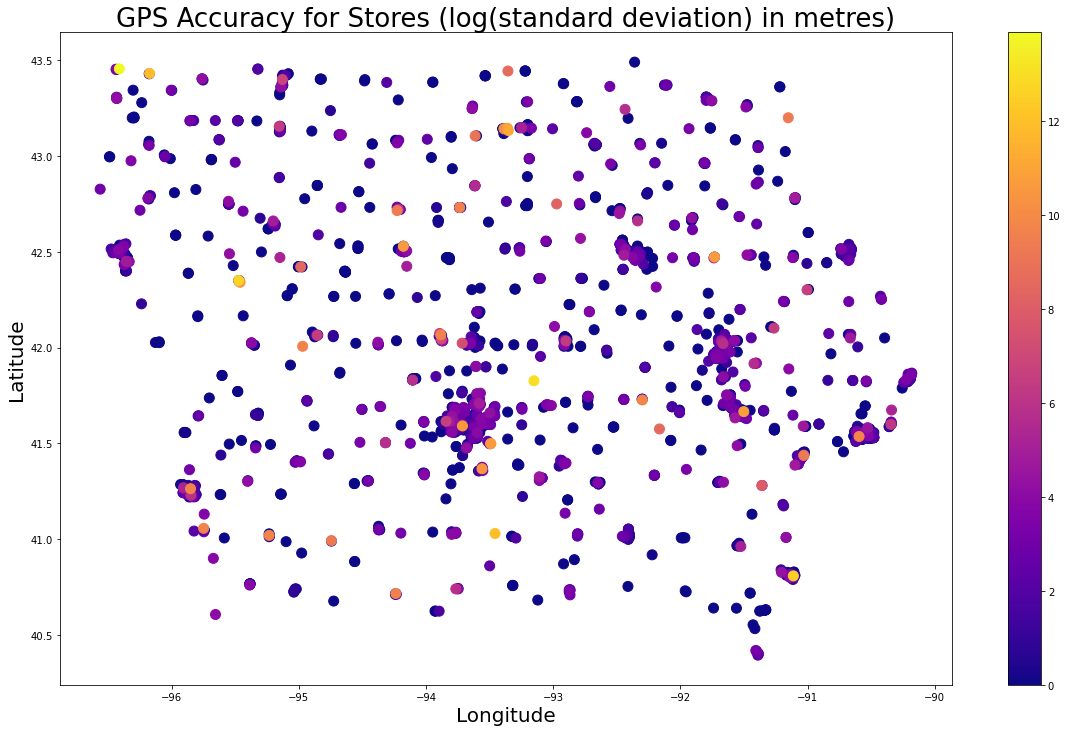

In [84]:
plt.subplots(figsize=(20, 12))
plt.scatter(gps_df["median_lon"], gps_df["median_lat"], c=np.log(gps_df["haversine"]+1), alpha=1, cmap="plasma", s=100)
plt.colorbar()
plt.title("GPS Accuracy for Stores (log(standard deviation) in metres)", fontsize=26)
plt.xlabel("Longitude", fontsize=20)
plt.ylabel("Latitude", fontsize=20)
plt.show()

### How good is location for business?

In [85]:
loc_sales = df_loc.groupBy("Store_Number", "Zip_Code", "Date").agg(
    F.first("median_lat").alias("lat"),
    F.first("median_lon").alias("lon"),
    F.sum("Sale_Dollars").alias("daily_sales")
).groupBy("Store_Number", "Zip_Code").agg(
    F.first("lat").alias("lat"),
    F.first("lon").alias("lon"),
    F.mean("daily_sales").alias("daily_sales"),
).toPandas()

In [86]:
loc_sales.sort_values("daily_sales", inplace=True)

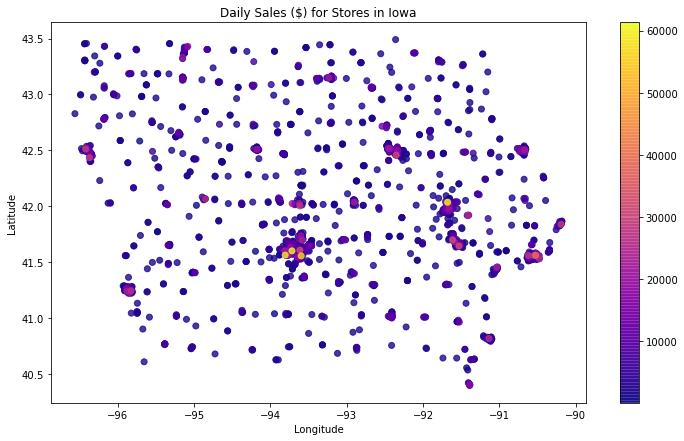

In [87]:
plt.subplots(figsize=(12, 7))
plt.scatter(loc_sales["lon"], loc_sales["lat"], c=loc_sales["daily_sales"], alpha=0.8, cmap="plasma")
plt.colorbar()
plt.title("Daily Sales (\$) for Stores in Iowa")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Popular brands & Drinks

### What kind of alcohol is most popular?

In [88]:
category_bottles = df.groupBy("Category").agg(
    F.first("Category_Name").alias("category"),
    F.sum("Bottles_Sold").alias("bottles")
).orderBy("bottles", ascending=False).toPandas()

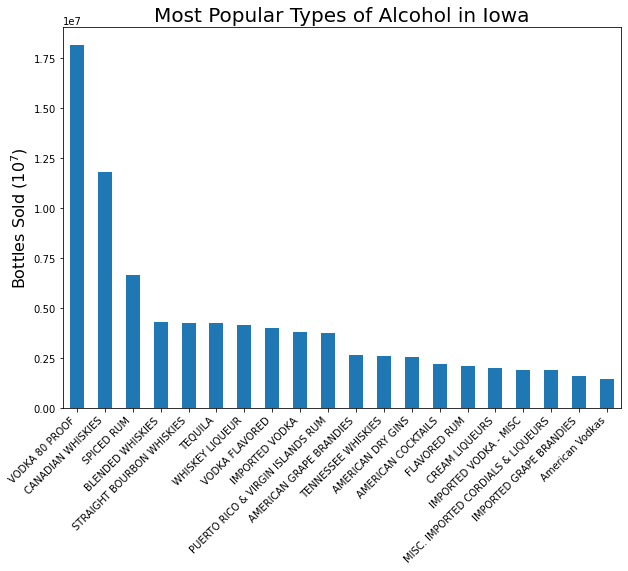

In [89]:
fig, ax = plt.subplots(figsize=(10,7))
category_bottles.head(20).plot.bar(x="category", y="bottles", ax=ax, legend=None)

plt.title("Most Popular Types of Alcohol in Iowa", fontsize=20)
plt.ylabel("Bottles Sold ($10^7$)", fontsize=16)
plt.xlabel("")
plt.xticks(rotation=45, ha="right")
plt.show()

### What brand of vodka is most popular?

In [91]:
vodka_bottles = df.filter(F.col("Category_Name") == "VODKA 80 PROOF") \
.groupBy("Item_Number").agg(
    F.first("Item_Description").alias("item"),
    F.sum("Bottles_Sold").alias("bottles")
).orderBy("bottles", ascending=False).toPandas()

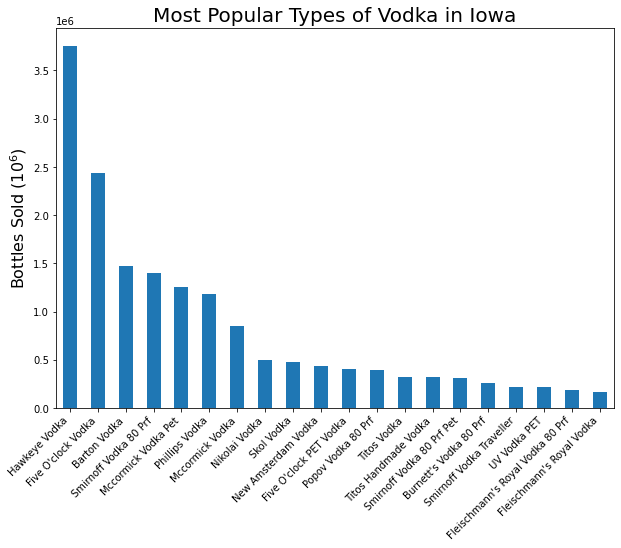

In [92]:
fig, ax = plt.subplots(figsize=(10,7))
vodka_bottles.groupby("item")[["bottles"]].sum().sort_values("bottles", ascending=False).head(20).plot.bar(ax=ax, legend=None)

plt.title("Most Popular Types of Vodka in Iowa", fontsize=20)
plt.ylabel("Bottles Sold ($10^6$)", fontsize=16)
plt.xlabel("")
plt.xticks(rotation=45, ha="right")
plt.show()

### Price vs Popularity

In [90]:
def fit_log_log_line(df, x, y):
    # Fits a linear line on a log-log graph
    
    d = df[[x, y]].applymap(np.log)
    d = d[(~d.isna() & (d > -np.inf)).all(axis=1)]

    coef = np.polyfit(d[x], d[y], 1)
    poly = np.poly1d(coef)

    def pred(x1):
        return np.exp(poly(np.log(x1)))
    
    return pred

In [93]:
price_pop = df.groupby("Item_Number").agg(
    F.first("Item_Description").alias("item"),
    F.sum("Volume_Sold_Liters").alias("volume"),
    F.sum("Sale_Dollars").alias("price")
).withColumn("price_per_litre", F.col("price") / F.col("volume")).toPandas()

In [94]:
loglog = fit_log_log_line(price_pop, "price_per_litre", "volume")

/opt/conda/anaconda/envs/jupyter/lib/python3.9/site-packages/pandas/core/frame.py:7603: RuntimeWarning: divide by zero encountered in log
  return lib.map_infer(x.astype(object)._values, func)


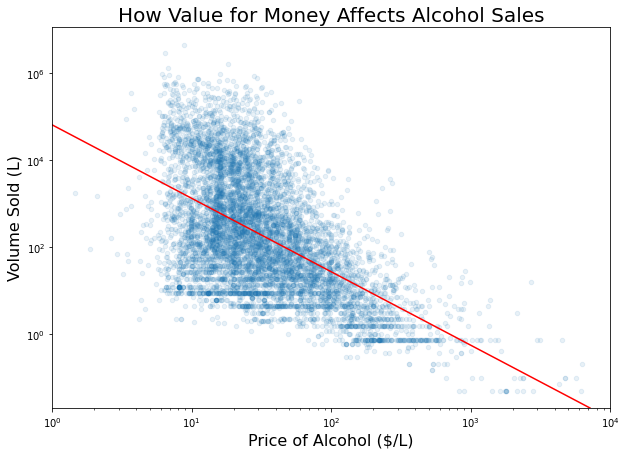

In [95]:
fig, ax = plt.subplots(figsize=(10, 7))
price_pop.plot.scatter(x="price_per_litre", y="volume", alpha=0.1, ax=ax)
plt.axline((10**1, loglog(10**1)), (10**3, loglog(10**3)), c="r")

plt.xscale("log")
plt.yscale("log")
plt.xlim(10**0, 10**4)

plt.title("How Value for Money Affects Alcohol Sales", fontsize=20)
plt.xlabel("Price of Alcohol (\$/L)", fontsize=16)
plt.ylabel("Volume Sold (L)", fontsize=16)
plt.show()

# Items commonly purchased together

In [5]:
def group_head(df, group_col, order_col, n):
    # https://stackoverflow.com/questions/38397796/retrieve-top-n-in-each-group-of-a-dataframe-in-pyspark
    window = Window.partitionBy(group_col).orderBy(df[order_col].desc())
    
    return df.withColumn("_rank", F.row_number().over(window)).filter(F.col("_rank") <= n).drop("_rank")

In [6]:
def build_matrix(inv_items_df, unique_items):
    # Creates a matrix of items bought together
    
    item_idx_mapping = {i:idx for idx,i in enumerate(unique_items)}
    idx_item_mapping = {idx:i for idx,i in enumerate(unique_items)}
    mat = np.zeros((len(idx_item_mapping), len(idx_item_mapping)), dtype=np.uint16)
    
    for j, item_list in enumerate(inv_items_df["items"]):
        if j % 1000 == 0:
            print("\r", j+1, "/", len(inv_items_df), end="", flush=True)
    
        for i, x in enumerate(item_list[:-1]):
            for y in item_list[i+1:]:
                mat[item_idx_mapping[x], item_idx_mapping[y]] += 1
                    
    return mat + mat.T, item_idx_mapping, idx_item_mapping

In [7]:
# Count bottles for each item in a transaction
inv_items = df.groupby("invoice_number", "Item_Number") \
.agg(F.sum("Bottles_Sold").alias("bottles"))

# Take the top N items from each transations
inv_items = group_head(inv_items, "invoice_number", "bottles", 20) \
    .groupby("invoice_Number") \
    .agg(F.collect_set("Item_Number").alias("items"))

# Take all items from each transaction
# inv_items = inv_items.groupby("invoice_Number") \
#     .agg(F.collect_set("Item_Number").alias("items"))

In [8]:
unique_items = df.select(F.collect_set("Item_Number")).toPandas().iloc[0,0]

In [9]:
inv_items_df = inv_items.toPandas()

In [10]:
occurrence_mat, item_idx_mapping, idx_item_mapping = build_matrix(inv_items_df, unique_items)

 30001 / 30751

In [11]:
del inv_items_df # massive amount of data to have in memory, delete since we dont need it anymore

In [79]:
# Sort and filter
sort = occurrence_mat.sum(axis=1).argsort()[::-1][:200]

<ipython-input-81-e8d306769341>:3: RuntimeWarning: invalid value encountered in true_divide
  ax.imshow((occurrence_mat / occurrence_mat.sum(axis=1, keepdims=True))[sort][:, sort])


Text(0, 0.5, 'Item Index')

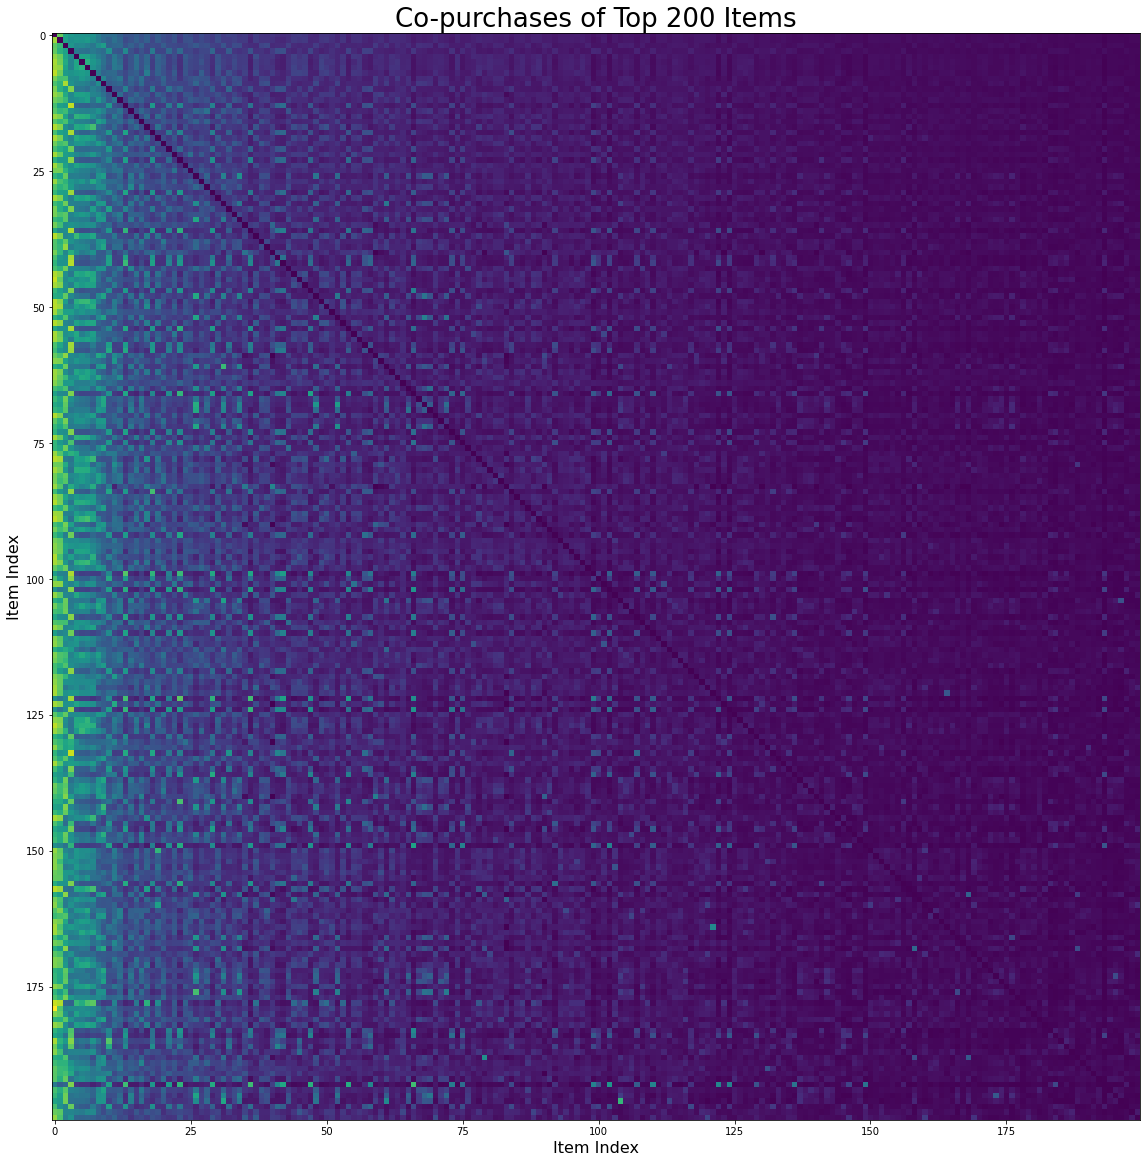

In [81]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow((occurrence_mat / occurrence_mat.sum(axis=1, keepdims=True))[sort][:, sort])
plt.title("Co-purchases of Top 200 Items", fontsize=26)
plt.xlabel("Item Index", fontsize=16)
plt.ylabel("Item Index", fontsize=16)

### Show top pairs bought together

In [12]:
top_10 = np.argpartition(occurrence_mat.ravel(), -10)[-10:]

In [26]:
seen = set()
item_item_bottles = []
for i, j in list(zip(*np.unravel_index(top_10, occurrence_mat.shape))):
    if tuple(sorted([i, j])) in seen:
        continue
        
    seen.add(tuple(sorted([i, j])))
    
    item_item_bottles.append([idx_item_mapping[i], idx_item_mapping[j], occurrence_mat[i, j]])

In [35]:
items = df.groupby("Item_Number") \
.agg(F.first("Item_Description").alias("name")).toPandas() \
.set_index("Item_Number", inplace=True)

In [45]:
iib = []
for i, j, bottles in item_item_bottles:
    iib.append({
        "Item A": items.loc[i, "name"],
        "Item B": items.loc[j, "name"],
        "Bottles Sold": bottles
    })

pd.DataFrame(iib).sort_values("Bottles Sold", ascending=False)

,Item A,Item B,Bottles Sold
1,Black Velvet,Hawkeye Vodka,13282
4,Mccormick Vodka Pet,Black Velvet,9864
2,Captain Morgan Spiced Rum,Black Velvet,9126
3,Black Velvet,Black Velvet,8561
0,Mccormick Vodka Pet,Hawkeye Vodka,8450
